In [1]:
import torch 
import pandas as pd
import cloudpickle
import numpy as np
import json

import ray

import networkx as nx
from ns.topos.fattree import build as build_fattree

from inference import Device
from ptm import deepPTM, load_model_from_ckpt

In [2]:
# Setup the model
with open('../configs/train_no_bidir_ALL_poisson_4.json') as f:
    specs = json.load(f)
    
model_specs = specs["model_specs"]

model = deepPTM(in_feat=13, # TODO: Get this from config or something.
                lstm_config=model_specs["lstm_config"],
                attn_config=model_specs["attn_config"],
                time_steps=specs["n_timesteps"],
                use_norm_time=specs['use_norm_time'])

load_model_from_ckpt(model, "../models/models_may/new_no_bidir_sch_ALL-tgen_Poisson-n_flows_100-n_ports_4_lr_0.001_steps_42/best_model.pt")
model.eval()

a = torch.zeros((4, 42, 13))
model(a).shape

torch.Size([4, 42])

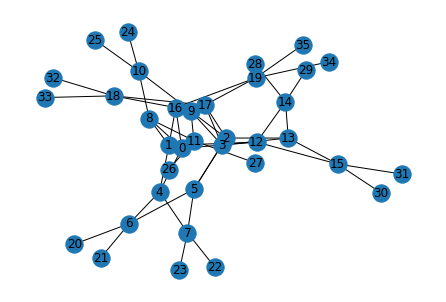

In [3]:
G = build_fattree(4)
diam_G = nx.diameter(G)
nx.draw(G, with_labels=True)

In [4]:
df = pd.read_csv('../data/rsim.csv')

with open('../data/rsim.flow_to_port', 'rb') as f:
    flow_to_port = cloudpickle.load(f)
    
with open('../data/rsim.port_to_nexthop', 'rb') as f:
    port_to_nexthop = cloudpickle.load(f)

def to_matrix(dict_to_convert, shape):
    matrix = np.zeros(shape, dtype=np.int32)
    for key, value in dict_to_convert.items():
        matrix[key, value] = 1
    return matrix

def to_tensor(dict_to_convert, shape):
    print(shape)
    tensor = np.zeros(shape, dtype=np.int32)
    for key, sub_dict in dict_to_convert.items():
        tensor[int(key)] = to_matrix(sub_dict, shape[1:])
    return tensor

all_devices = pd.unique(df['cur_hub'])
num_ports = len(pd.unique(df['cur_port']))
num_flows = len(pd.unique(df['flow_id']))

port_to_nexthop_tensor = to_tensor(port_to_nexthop, (len(all_devices), num_ports, len(all_devices)))
flow_to_port_tensor = to_tensor(flow_to_port, (len(all_devices), num_flows, num_ports))

(36, 4, 36)
(36, 100, 4)


In [5]:
# Get initial devices and packets to simulate.
# initial_packets = df.loc[df['path'].apply(lambda x: "-" not in x)].copy()
initial_packets = df.loc[df['cur_hub'] >= 20].copy()
initial_devices = pd.unique(initial_packets['cur_hub'])
# Give all the packets a pid
initial_packets['pid'] = np.arange(len(initial_packets))
initial_packets.set_index('pid', inplace=True)

devices = [None] * len(all_devices)
for d in all_devices:
    if d in initial_devices:
        devices[d] = Device(d, initial_packets.loc[initial_packets['cur_hub'] == d], port_to_nexthop_tensor[d], flow_to_port_tensor)
    else:
        devices[d] = Device(d, pd.DataFrame(columns=df.columns), port_to_nexthop_tensor[d], flow_to_port_tensor)

# TODO: The device should NOT be instantiated with the dataframe of initial packets, rather this should be passed in the initial_forward()

In [6]:
# IRSA pt. 1, forwarding all the initial packets
for _ in range(diam_G):
    # Forward in parallel, and aggregate in parallel.
    forward_dicts = [dev.initial_forward() for dev in devices]
    res = [dev.aggregate(forward_dicts, initial=True) for dev in devices]
    print(any(res))

# Ensure that all the packets are accounted for
tmp_df = pd.concat([dev.get_df() for dev in devices])
assert len(tmp_df) == len(df)

True
True
True
True
True
False


In [7]:
# IRSA pt. 2
for step in range(diam_G):
    print(step)
    forward_dicts = [dev.forward(model) for dev in devices]
    res = [dev.aggregate(forward_dicts) for dev in devices]

    # Break if no updates were made.
    print(any(res))
    if not any(res):
        break
        
print(f"Took {step} steps")
# Now we can get the final dataframe simply by extracting the dataframes, concatentating, and re-sorting on timestamp.
final_df = pd.concat([dev.get_df() for dev in devices]).sort_values('timestamp')
print(len(final_df))

0
True
1


KeyError: "['mean_load_port_0', 'mean_load_port_1', 'mean_load_port_2', 'mean_load_port_3'] not in index"

In [ ]:
# We can now inspect packet by packet:
df_packet = final_df[final_df.index == 0]
df_packet
# print(len(final_df))

,timestamp,pkt_len,cur_hub,cur_port,path,priority,flow_id,scheduler,etime
0,0.000425,1019,25,0,25_0,1.0,2,FIFO,0.00058
0,0.000580,1019,10,1,25_0,1.0,2,FIFO,0.00358
0,0.003580,1019,9,3,25_0,1.0,2,FIFO,0.00658
0,0.006580,1019,3,0,25_0,1.0,2,FIFO,0.00958
0,0.009580,1019,5,0,25_0,1.0,2,FIFO,0.01258
0,0.012580,1019,6,2,25_0,1.0,2,FIFO,0.01558
